# Chapter 5 - Image Restoration and Reconstruction
Importing libs and testing

In [111]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from skimage import io, img_as_float, img_as_ubyte,
from skimage.util import random_noise
from skimage.draw import polygon
from scipy.signal import fftconvolve, convolve2d

### 5.2.1 - Adding Noise to Images with Function imnoise

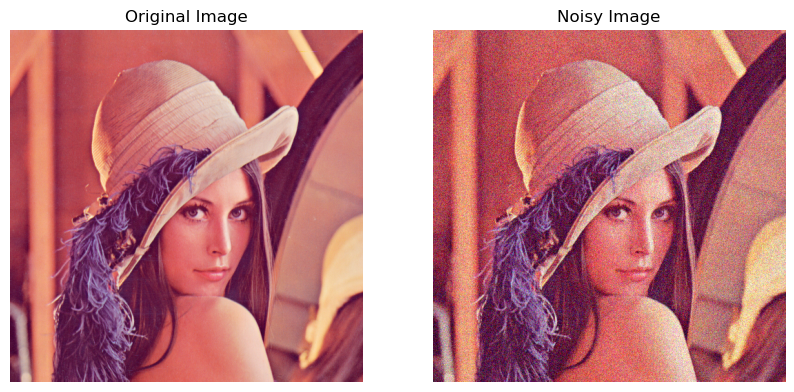

In [2]:
# Load an example image
image = io.imread('../database/chapter_2/lenna.png')
image = img_as_float(image)  # Convert image to float format

# Define noise type and parameters
noise_type = 'gaussian'  # Example noise type, you can use 'salt', 'pepper', 's&p', 'speckle', etc.
parameters = {'var': 0.01}  # Example parameter for Gaussian noise, variance of 0.01

# Add noise to the image
noisy_image = random_noise(image, mode=noise_type, **parameters)

# Display the original and noisy images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

plt.show()

### 5.2.2 - Generating Spatial Random Noise with a Specified 
Distributonb

In [3]:
def imnoise2(noise_type, *args):
    # Set defaults
    M, N, a, b = set_defaults(noise_type, *args)
    
    # Begin processing based on noise type
    if noise_type.lower() == 'uniform':
        R = a + (b - a) * np.random.rand(M, N)
    elif noise_type.lower() == 'gaussian':
        R = a + b * np.random.randn(M, N)
    elif noise_type.lower() == 'salt & pepper':
        R = salt_pepper(M, N, a, b)
    elif noise_type.lower() == 'lognormal':
        R = np.exp(b * np.random.randn(M, N) + a)
    elif noise_type.lower() == 'rayleigh':
        R = a + (-b * np.log(1 - np.random.rand(M, N))) ** 0.5
    elif noise_type.lower() == 'exponential':
        R = exponential(M, N, a)
    elif noise_type.lower() == 'erlang':
        R = erlang(M, N, a, b)
    else:
        raise ValueError('Unknown distribution type.')
    
    return R

def set_defaults(noise_type, *args):
    # Unpack arguments
    params = list(args) + [None] * (4 - len(args))
    M = params[0] if params[0] is not None else 1
    N = params[1] if params[1] is not None else 1
    a = params[2]
    b = params[3]

    if noise_type.lower() == 'salt & pepper':
        a = 0.05 if a is None else a
        b = 0.05 if b is None else b
    elif noise_type.lower() == 'lognormal':
        a = 1 if a is None else a
        b = 0.25 if b is None else b
    elif noise_type.lower() == 'exponential':
        a = 1 if a is None else a
    elif noise_type.lower() == 'erlang':
        a = 2 if a is None else a
        b = 5 if b is None else b
    else:
        a = 0 if a is None else a
        b = 1 if b is None else b
    
    return M, N, a, b

def salt_pepper(M, N, a, b):
    if (a + b) > 1:
        raise ValueError('The sum Pa + Pb must not exceed 1.')

    R = 0.5 * np.ones((M, N))
    X = np.random.rand(M, N)
    R[X <= a] = 0
    u = a + b
    R[(X > a) & (X <= u)] = 1
    return R

def exponential(M, N, a):
    if a <= 0:
        raise ValueError('Parameter a must be positive for exponential type.')
    k = 1 / a
    return k * np.log(1 - np.random.rand(M, N))

def erlang(M, N, a, b):
    if b != round(b) or b <= 0:
        raise ValueError('Param b must be a positive integer for Erlang.')
    k = 1 / a
    R = np.zeros((M, N))
    for _ in range(int(b)):
        R += k * np.log(1 - np.random.rand(M, N))
    return R

In [4]:
noise_type = 'gaussian'
M, N = 5, 5
a, b = 0, 1
R = imnoise2(noise_type, M, N, a, b)
print(R)

[[-0.07676508  0.06986305 -0.5321079   0.19023674 -0.77163   ]
 [ 0.38835859  1.80335073 -0.38116523 -0.02151952 -1.63981514]
 [ 0.12213117  1.00257046 -0.55291451  0.03835426 -0.32270017]
 [-0.37774808 -1.40846804  0.21926918  1.04430511  0.19222778]
 [-0.23386417  0.2597727  -0.83968265  0.20585012  1.26273428]]


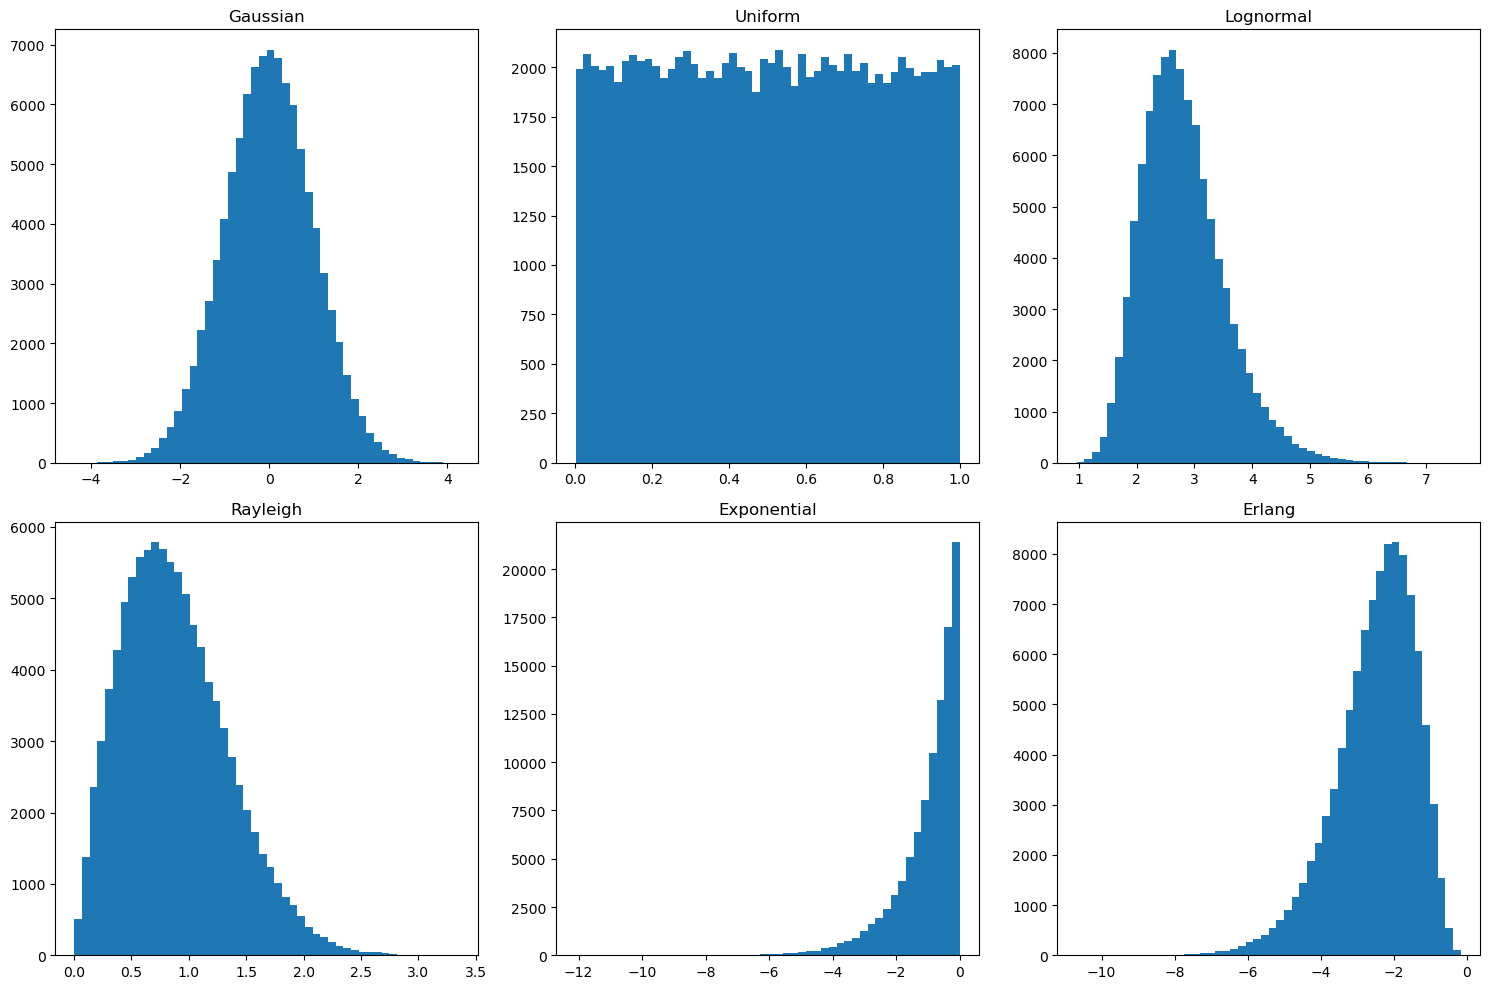

In [11]:
# Generate data and plot histograms
noise_types = ['gaussian', 'uniform', 'lognormal', 'rayleigh', 'exponential', 'erlang']
data_params = {
    'gaussian': (100000, 1),
    'uniform': (100000, 1),
    'lognormal': (100000, 1),
    'rayleigh': (100000, 1),
    'exponential': (100000, 1),
    'erlang': (100000, 1)
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, noise_type in enumerate(noise_types):
    r = imnoise2(noise_type, *data_params[noise_type]).flatten()
    axs[i].hist(r, bins=50)
    axs[i].set_title(noise_type.capitalize())
    # axs[i].set_xlim(left=0)

plt.tight_layout()
plt.show()

### 5.2.3 - Periodic Noise

In [12]:
import numpy as np

def imnoise3(M, N, C, A=None, B=None):
    """
    Generates periodic noise.

    Parameters:
    - M, N: Size of the noise pattern.
    - C: K-by-2 matrix with frequency domain coordinates (u, v) that define the locations of impulses.
    - A: A 1-by-K vector containing the amplitude of each impulse pair. Defaults to ones(1, K).
    - B: A K-by-2 matrix containing the Bx and By phase components for each impulse pair. Defaults to zeros(K, 2).

    Returns:
    - r: Spatial sinusoidal noise pattern of size M-by-N.
    - R: Fourier transform of the noise pattern.
    - S: Spectrum of the noise pattern.
    """
    K = C.shape[0]
    
    if A is None:
        A = np.ones(K)
    if B is None:
        B = np.zeros((K, 2))

    R = np.zeros((M, N), dtype=np.complex128)
    
    for j in range(K):
        u1 = np.floor(M/2) + 1 - C[j, 0]
        v1 = np.floor(N/2) + 1 - C[j, 1]
        R[int(u1), int(v1)] = 1j * M * N * (A[j] / 2) * np.exp(-1j * 2 * np.pi * (C[j, 0] * B[j, 0] / M + C[j, 1] * B[j, 1] / N))
        
        u2 = np.floor(M/2) + 1 + C[j, 0]
        v2 = np.floor(N/2) + 1 + C[j, 1]
        R[int(u2), int(v2)] = -1j * M * N * (A[j] / 2) * np.exp(1j * 2 * np.pi * (C[j, 0] * B[j, 0] / M + C[j, 1] * B[j, 1] / N))
    
    S = np.abs(R)
    r = np.real(np.fft.ifft2(np.fft.ifftshift(R)))
    
    return r, R, S


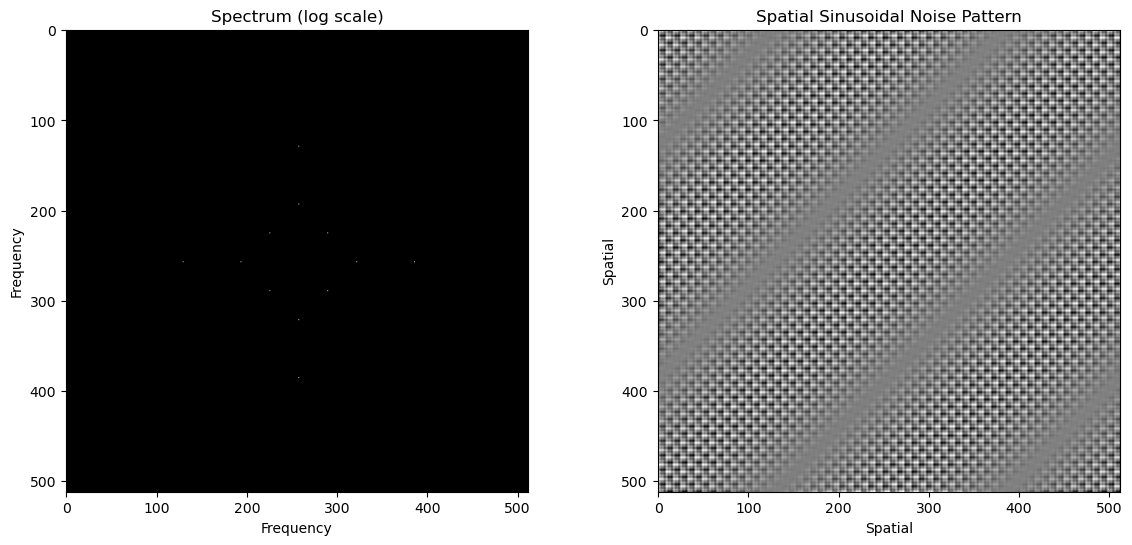

In [15]:
# Define the impulse locations
C = np.array([[0, 64],
              [0, 128],
              [32, 32],
              [64, 0],
              [128, 0],
              [-32, 32]])

# Generate spatial sinusoidal noise pattern
r, R, S = imnoise3(512, 512, C)

# Plot spectrum and spatial sinusoidal noise pattern side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot spectrum
axs[0].imshow(np.log(S + 1e-10), cmap='gray')  # Add small value to avoid log(0)
axs[0].set_title('Spectrum (log scale)')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Frequency')
axs[0].grid(False)

# Plot spatial sinusoidal noise pattern
axs[1].imshow(r, cmap='gray')
axs[1].set_title('Spatial Sinusoidal Noise Pattern')
axs[1].set_xlabel('Spatial')
axs[1].set_ylabel('Spatial')
axs[1].grid(False)

plt.show()

### 5.2.4 - Estimating Noise Parameters 

In [30]:
def hist_roi(f, c, r):
    # Generate the binary mask image.
    mask = np.zeros_like(f, dtype=np.uint8)
    rr, cc = polygon(r, c)
    mask[rr, cc] = 255
    
    # Convert mask to single channel (grayscale)
    mask_single_channel = mask[:,:,0]  # Selecting the first channel
    
    # Compute the histogram of the pixels in the ROI
    p, _ = np.histogram(f[mask_single_channel > 0], bins=256, range=(0, 255))
    
    # Flatten mask to count non-zero pixels
    npix = np.count_nonzero(mask_single_channel)
    
    return p, npix

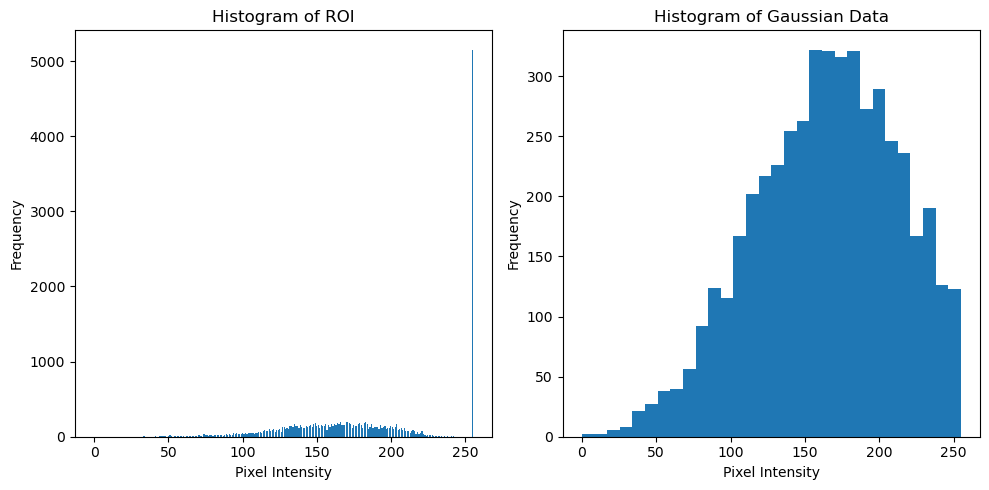

In [31]:
f = io.imread('../database/chapter_5/noisy_image.png')

# Interactive selection of ROI
c = [50, 100, 150, 150, 100]  # column coordinates of vertices
r = [100, 100, 50, 150, 150]   # row coordinates of vertices

# Compute histogram and number of pixels in ROI
h, npix = hist_roi(f, c, r)

# Estimate mean and variance of the noise
mean_est = np.mean(f)
variance_est = np.var(f)

# Generate Gaussian random variables using estimated parameters
X = np.random.normal(mean_est, np.sqrt(variance_est), size=npix)

# Plot histograms for comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(h)), h)
plt.title('Histogram of ROI')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(X, bins=30, range=(0, 255))
plt.title('Histogram of Gaussian Data')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5.3 - Restoration in the Presence of Noise Only-Spatial Filtering

### 5.3.1 - Spatial Noise Filtersg

In [43]:
def spfilt(g, type, *args):
    m, n, a, d = process_inputs(*args)

    if type == 'amean':
        w = np.ones((m, n), dtype=np.float32) / (m * n)
        f = cv2.filter2D(g, -1, w, borderType=cv2.BORDER_REPLICATE)

    elif type == 'gmean':
        f = gmean(g, m, n)

    elif type == 'hmean':
        f = harmean(g, m, n)

    elif type == 'chmean':
        f = charmean(g, m, n, a)

    elif type == 'median':
        f = cv2.medianBlur(g, m)

    elif type == 'max':
        f = cv2.dilate(g, np.ones((m, n), dtype=np.uint8))

    elif type == 'min':
        f = cv2.erode(g, np.ones((m, n), dtype=np.uint8))

    elif type == 'midpoint':
        f = midpoint(g, m, n)

    elif type == 'atrimmed':
        f = alphatrim(g, m, n, d)

    else:
        raise ValueError('Unknown filter type.')

    return f

def gmean(g, m, n):
    return np.exp(cv2.boxFilter(np.log(g.astype(np.float32) + 1e-6), -1, (m, n)))

def harmean(g, m, n):
    return m * n / cv2.boxFilter(1 / (g.astype(np.float32) + 1e-6), -1, (m, n))

def charmean(g, m, n, q):
    g = g.astype(np.float32)
    epsilon = 1e-6
    zero_mask = (g == 0)
    
    # Replace zero values with a small positive value
    g[zero_mask] = epsilon
    
    numerator = cv2.boxFilter(g ** (q + 1), -1, (m, n))
    denominator = cv2.boxFilter(g ** q, -1, (m, n))
    
    # Handle division by zero
    denominator[denominator == 0] = epsilon
    
    return numerator / denominator

def alphatrim(g, m, n, d):
    if d <= 0 or d % 2 != 0:
        raise ValueError('d must be a positive, even integer.')
    
    f = cv2.boxFilter(g, -1, (m, n))
    for k in range(1, d // 2 + 1):
        f -= cv2.erode(g, np.ones((k, k), dtype=np.uint8))
    for k in range(g.size - d // 2, g.size + 1):
        f -= cv2.erode(g, np.ones((k, k), dtype=np.uint8))
    return f / (g.size - d)

def process_inputs(*args):
    m = 3
    n = 3
    a = 1.5
    d = 2
    
    if len(args) > 0:
        m = args[0]
    if len(args) > 1:
        n = args[1]
    if len(args) > 2:
        a = args[2]
        d = args[2]
    
    return m, n, a, d

def generate_noisy_image(image, noise_type, p1, p2):
    noisy_image = np.copy(image)
    M, N = image.shape

    if noise_type == 'salt & pepper':
        R = np.random.rand(M, N)
        noisy_image[R < p1] = 0
        noisy_image[R > (1 - p2)] = 255

    return noisy_image

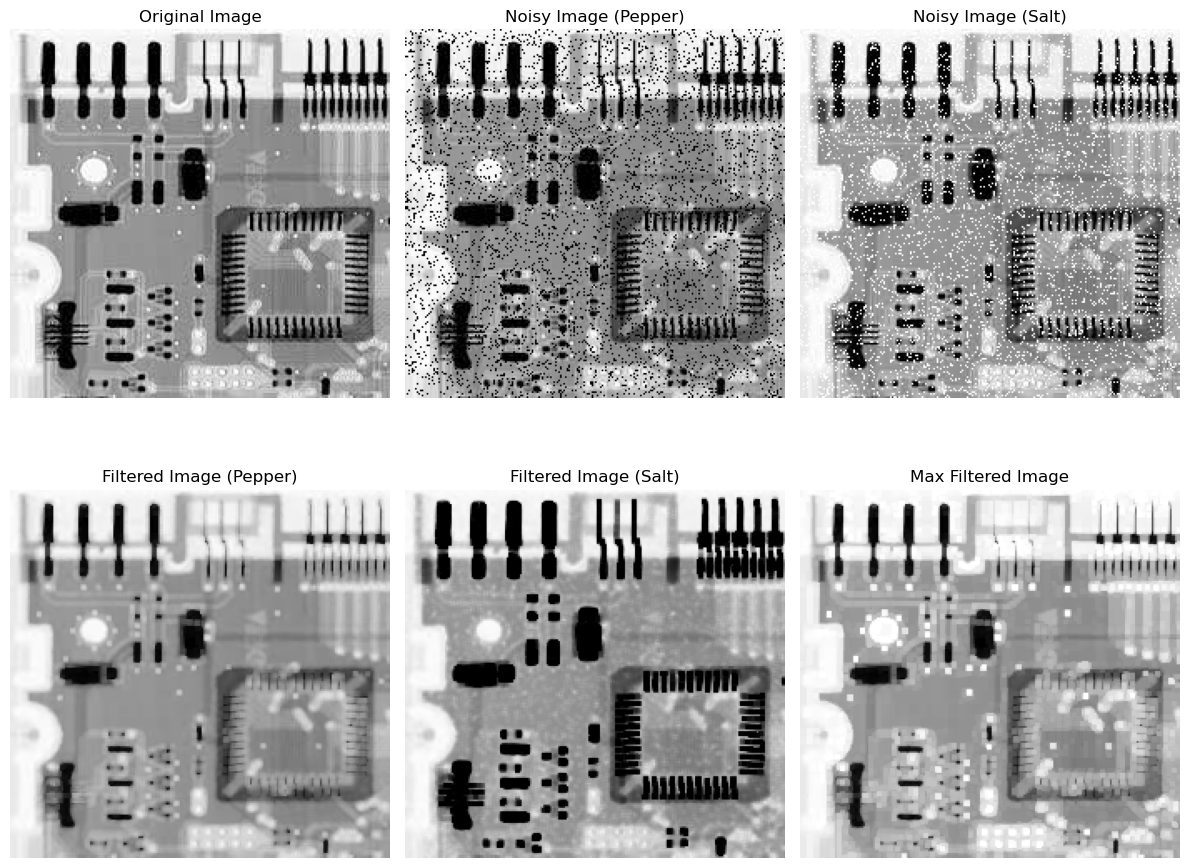

In [46]:
# Load the original image
f = cv2.imread('../database/chapter_5/board.jpg', cv2.IMREAD_GRAYSCALE)

# Generate noisy images
gp = generate_noisy_image(f, 'salt & pepper', 0.1, 0)
gs = generate_noisy_image(f, 'salt & pepper', 0, 0.1)

# Apply contraharmonic filter for pepper noise
fp = spfilt(gp, 'chmean', 3, 3, 1.5)

# Apply contraharmonic filter for salt noise
fs = spfilt(gs, 'chmean', 3, 3, -1.5)

# Apply max and min filters
fpmax = spfilt(gp, 'max', 3, 3)
fsmin = spfilt(gs, 'min', 3, 3)

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
plt.imshow(f, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(gp, cmap='gray')
plt.title('Noisy Image (Pepper)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(gs, cmap='gray')
plt.title('Noisy Image (Salt)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(fp, cmap='gray')
plt.title('Filtered Image (Pepper)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fs, cmap='gray')
plt.title('Filtered Image (Salt)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(fpmax, cmap='gray')
plt.title('Max Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

### 5.3.2 - Adaptive Spatial Filters 

In [56]:
def adpmedian(g, Smax):
    rows, cols = g.shape
    filtered_image = np.zeros_like(g)
    
    for x in range(rows):
        for y in range(cols):
            # Construct the subimage Sxy centered at (x, y)
            subimage = g[max(0, x - Smax//2):min(rows, x + Smax//2 + 1),
                          max(0, y - Smax//2):min(cols, y + Smax//2 + 1)]
            
            # Calculate Zmin, Zmax, and Zmed
            Zmin = np.min(subimage)
            Zmax = np.max(subimage)
            Zmed = np.median(subimage)
            Zxy = g[x, y]
            
            # Adaptive median filtering algorithm
            if Zmin < Zxy < Zmax:
                filtered_image[x, y] = Zxy
            else:
                filtered_image[x, y] = Zmed
    
    return filtered_image

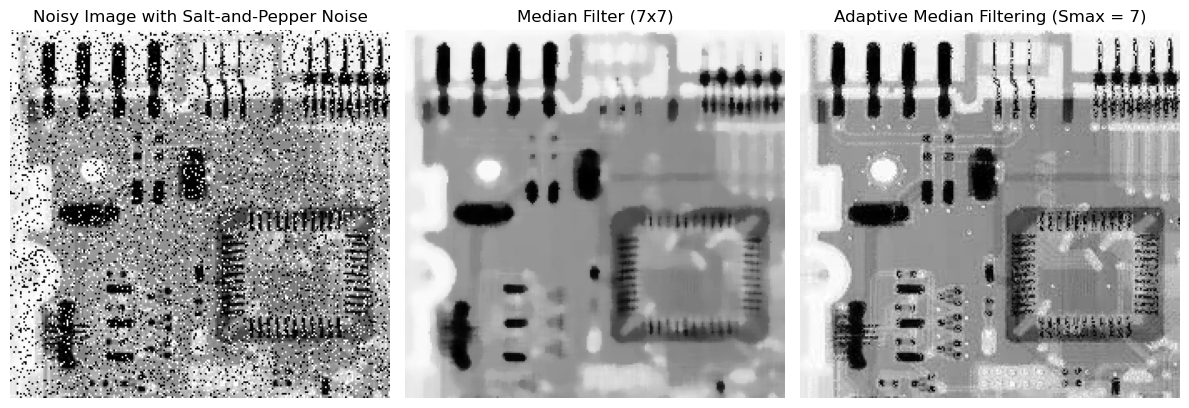

In [57]:
# Generate a noisy image with salt-and-pepper noise
noisy_image = generate_noisy_image(f, 'salt & pepper', 0.1, 0.1)

# Apply median filter of size 7x7
median_filtered_image = cv2.medianBlur(noisy_image, 7)

# Apply adaptive median filtering with Smax = 7
adaptive_median_filtered_image = adpmedian(noisy_image, 7)

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image with Salt-and-Pepper Noise')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(median_filtered_image, cmap='gray')
plt.title('Median Filter (7x7)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(adaptive_median_filtered_image, cmap='gray')
plt.title('Adaptive Median Filtering (Smax = 7)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 5.5 - Modeling the Degradation Function


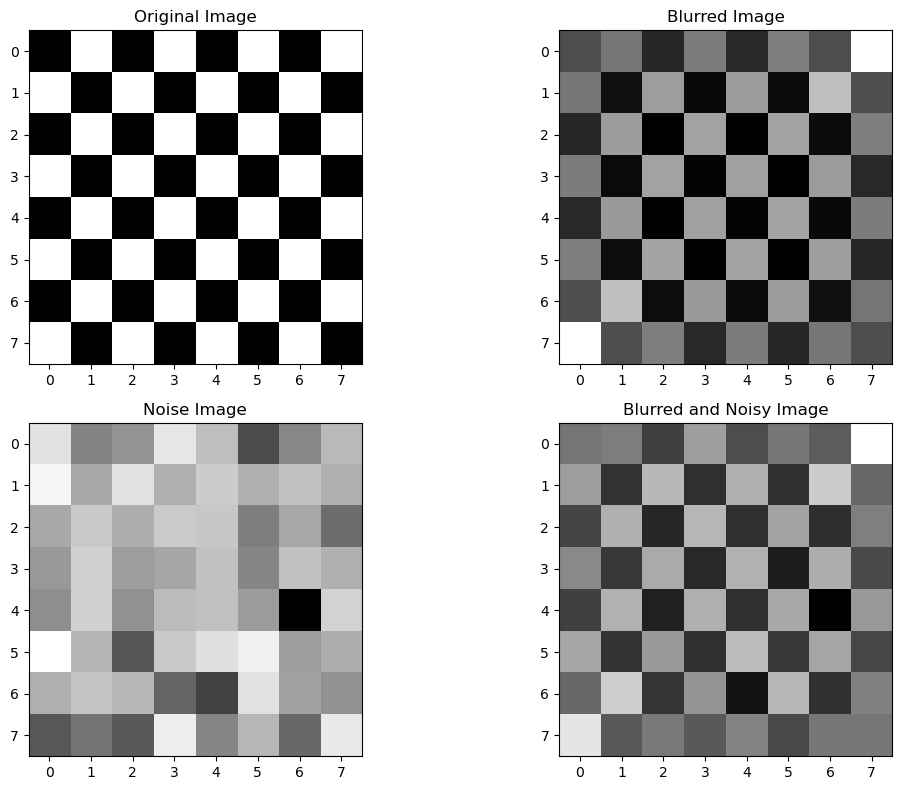

In [107]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def checkerboard(N, M):
    return np.indices((N, M)).sum(axis=0) % 2

def imfilter(image, psf):
    return cv2.filter2D(image, -1, psf, borderType=cv2.BORDER_REPLICATE)

def imnoise_gaussian(shape, mean, var):
    return np.random.normal(mean, var, shape)

# Generating checkerboard image
N, M = 8, 8
f = checkerboard(N, M)

# Generating motion PSF
PSF_size = 7
PSF_angle = 45
PSF = np.zeros((PSF_size, PSF_size), dtype=np.float32)
PSF[int((PSF_size - 1) / 2), :] = cv2.getGaussianKernel(PSF_size, -1)[:, 0]
M = cv2.getRotationMatrix2D(((PSF_size - 1) / 2, (PSF_size - 1) / 2), PSF_angle, 1)
PSF = cv2.warpAffine(PSF, M, (PSF_size, PSF_size))

# Filtering image with PSF
blurred_image = imfilter(f.astype(np.float32), PSF)

# Generating noise image
noise_image = imnoise_gaussian(f.shape, 0, np.sqrt(0.001))

# Adding noise to blurred image
blurred_and_noisy_image = blurred_image + noise_image

# Displaying the images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(f, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')

plt.subplot(2, 2, 3)
plt.imshow(noise_image, cmap='gray')
plt.title('Noise Image')

plt.subplot(2, 2, 4)
plt.imshow(blurred_and_noisy_image, cmap='gray')
plt.title('Blurred and Noisy Image')

plt.tight_layout()
plt.show()


## 5.6 - Direct Inverse Filtering

In [108]:
# Function to calculate the Wiener deconvolution
def wiener_deconvolution(image, PSF, R):
    # Fourier transform of image and PSF
    G = np.fft.fft2(image)
    H = np.fft.fft2(PSF, s=image.shape)
    
    # Wiener filter
    F_restored = np.fft.ifft2(np.conj(H) * G / (np.abs(H)**2 + R))
    
    # Return the real part of the inverse Fourier transform
    return np.real(F_restored)

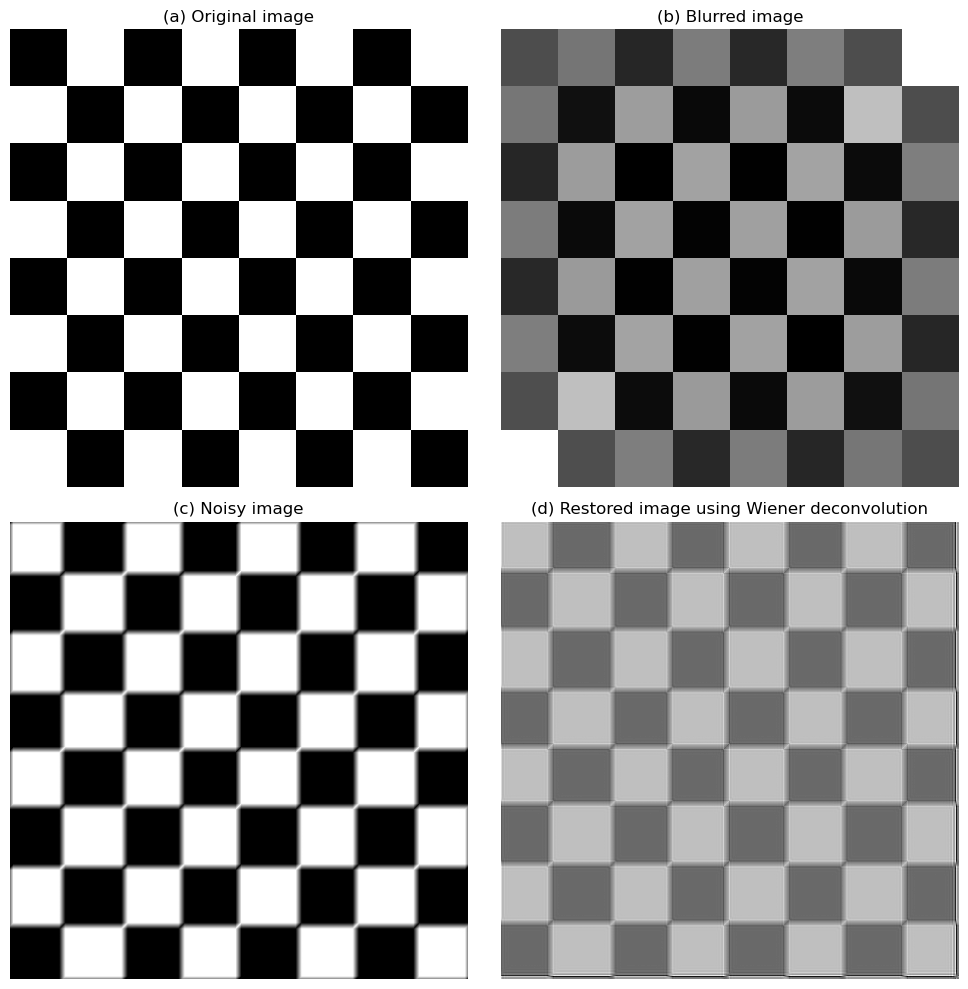

In [109]:
# Calculate power spectra
Sn = np.abs(np.fft.fft2(noise_image))**2  # Noise power spectrum
Sf = np.abs(np.fft.fft2(blurred_image))**2  # Image power spectrum
nA = np.sum(Sn) / np.prod(noise_image.shape)  # Noise average power
fA = np.sum(Sf) / np.prod(blurred_image.shape)  # Image average power

# Calculate ratio
R = nA / fA

# Apply Wiener deconvolution
restored_image = wiener_deconvolution(noisy_image, PSF, R)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot original image
axs[0, 0].imshow(f, cmap='gray')
axs[0, 0].set_title('(a) Original image')
axs[0, 0].axis('off')

# Plot blurred image
axs[0, 1].imshow(blurred_image, cmap='gray')
axs[0, 1].set_title('(b) Blurred image')
axs[0, 1].axis('off')

# Plot noisy image
axs[1, 0].imshow(noisy_image, cmap='gray')
axs[1, 0].set_title('(c) Noisy image')
axs[1, 0].axis('off')

# Plot restored image
axs[1, 1].imshow(restored_image, cmap='gray')
axs[1, 1].set_title('(d) Restored image using Wiener deconvolution')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 5.8 - Constrained Least Squares (Regularized) Filtering

In [117]:
def richardson_lucy(image, psf, iterations=30):
    # Initialize the restored image
    restored_image = np.copy(image)
    
    # Normalize the PSF
    psf /= np.sum(psf)
    
    # Iterate Richardson-Lucy algorithm
    for _ in range(iterations):
        # Calculate the error
        error = image / (convolve2d(restored_image, psf, 'same') + 1e-10)
        
        # Update the restored image
        restored_image *= convolve2d(error, np.rot90(psf, 2), 'same')
    
    return restored_image

# Load the blurred and noisy image (g) and the point spread function (PSF)
g = blurred_and_noisy_image
PSF = PSF  # Use the PSF from the previous part

# Perform Richardson-Lucy deconvolution
f_restored = richardson_lucy(g, PSF)

# Display the restored image
plt.figure(figsize=(8, 4))
plt.imshow(f_restored, cmap='gray')
plt.title('Restored Image')
plt.axis('off')
plt.show()

NameError: name 'convolve2d' is not defined